# Chapter 13 - Tectonic-scale models and modelling tools

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from scipy.optimize import fsolve
from scipy.special import lambertw
from scipy.integrate import odeint, quad

## Corner-flow with magmatic segregation

This simplified problem is governed by the system

\begin{align}
    \label{eq:cornerflow-twophase-stokes}
    \Grad\pres = \delsq\vel \\
    \Div\vel = 0
\end{align}

and

\begin{equation*}
\vel\liq = \vel - \frac{1}{\velratio}\left(\Grad\pres + \unit{\gravity}\right)
\end{equation*}

The nondimensional solution to \eqref{eq:cornerflow-twophase-stokes} is

\begin{align}
    f(\theta) &= A\sin\theta -B\theta\cos\theta, \\
    \vel &= \left[f'(\theta)\rhat - f(\theta)\thetahat\right], \\
    \pres &= -\frac{1}{r}\left[f'''(\theta) + f'(\theta)\right] = -\frac{2B}{r}\cos\theta,
\end{align}

where

\begin{equation*}
  A = \frac{2\sin^2\theta_p}{\pi - 2\theta_p-\sin2\theta_2}
  \text{ and }
  B = \frac{2}{\pi - 2\theta_p-\sin2\theta_2}.
\end{equation*}

Recall that $\theta_p$ is the angle beneath the horizontal made by the base of the rigid wedge that represents the lithosphere.  Using the cylindrical coordinate system,

\begin{align}
  \unit{\gravity} &= \cos\theta\rhat - \sin\theta\thetahat,\\
  \Grad\pres &= \pdiff{\pres}{r}\rhat + \frac{1}{r}\pdiff{\pres}{\theta}\thetahat.
\end{align}

The liquid velocity is then

\begin{equation}
  \label{eq:cornerflow-liquid-velocity}
  \vel\liq = \left(f'(\theta)\rhat - f(\theta)\thetahat\right) -
  \frac{1}{\velratio}\left\{\frac{1}{r^2}\left[\left(f''' +f'\right)\rhat - \left(f'''' + f''\right)\thetahat\right]
    + \cos\theta\rhat + \sin\theta\thetahat\right\}.
\end{equation}

The radial and tangential components of the solid and liquid velocities are implemented as:

In [3]:
def vel_solid_radial(alph, theta):
    return -(2.*np.sin(alph)**2 * np.cos(theta) - 2.*np.cos(theta) 
             + 2.*theta*np.sin(theta))/(2.*alph - np.pi + np.sin(2.*alph))

def vel_solid_tangential(alph, theta):
    return (2.*np.sin(alph)**2 * np.sin(theta) - 2.*theta*np.cos(theta))/(2.*alph - np.pi + np.sin(2.*alph))

def vel_liquid_radial(alph, theta, r, e):
    sin_a = np.sin(alph)
    sin_t = np.sin(theta)
    cos_t = np.cos(theta)
    numer = 2.*sin_a**2 * cos_t - 2.*cos_t + 2.*theta*sin_t
    denom = 2.*alph - np.pi + np.sin(2.*alph)
    return -numer/denom - (cos_t - ((numer/denom - (2.*sin_a**2 * cos_t - 6.*cos_t + 2.*theta*sin_t)/denom))/r**2)/e

def vel_liquid_tangential(alph, theta, r, e):
    sin_t = np.sin(theta)
    sin_a = np.sin(alph)
    cos_t = np.cos(theta)
    numer = -2.*sin_a**2 * sin_t + 2.*theta*cos_t
    denom = 2.*alph - np.pi + np.sin(2.*alph)
    return (sin_t - ((4.*sin_t + numer)/denom - (8.*sin_t + numer)/denom)/r**2)/e - numer/denom

Figures below plot the streamlines of the solid (4) and liquid \eqref{eq:cornerflow-liquid-velocity} velocities for the corner flow solution with uniform viscosity and porosity. The domain has a fixed size in dimensional units. The top row of panels has a larger lithospheric wedge angle $(\theta_p=30^\circ)$ than the bottom row $(\theta_p=15^\circ)$.  The left column has 100$\times$ slower melt segregation ($\velratio=1$) than the right column ($\velratio=0.01$).

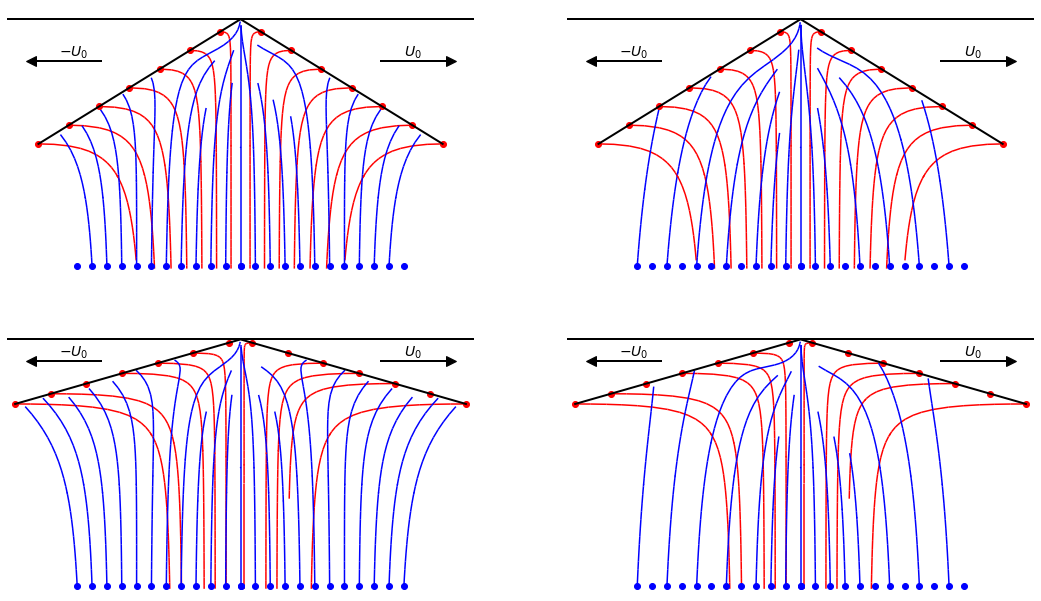

In [4]:
f, ax = plt.subplots(2, 2)
zoom = 2.0
f.set_size_inches(9.2 * zoom, 5.4 * zoom)
f.set_facecolor('w')

Ny = 500
aspect = 2.0
Nx = np.round(Ny*aspect)
x = np.linspace(-0.5*aspect, 0.5*aspect, Nx)
y = np.linspace(0.0, 1.0, Ny)
X, Y = np.meshgrid(x, y)
theta = -np.arctan2(Y, X) + 0.5*np.pi

seedVS = np.zeros([7, 2])
seedVL = np.zeros([12, 2])

L = 0.2
evec = np.asarray([1, 0.01])
alphvec = np.asarray([30*np.pi/180., 15*np.pi/180.])
r = np.sqrt(X**2 + Y**2)/L

for i, alph in enumerate(alphvec):
    B = 2./(np.pi - 2*alph - np.sin(2.*alph))
    inplates = np.fabs(theta) > (0.5 * np.pi - alph)
    Lf = L * np.sqrt(2*B)
    for j, e in enumerate(evec):
        VSR = vel_solid_radial(alph, theta)
        VST = vel_solid_tangential(alph, theta)
        VLR = vel_liquid_radial(alph, theta, r, e)
        VLT = vel_liquid_tangential(alph, theta, r, e)
        VSX = VSR * np.sin(theta) + VST * np.cos(theta)
        VSY = VSR * np.cos(theta) - VST * np.sin(theta)
        VLX = VLR * np.sin(theta) + VLT * np.cos(theta)
        VLY = VLR * np.cos(theta) - VLT * np.sin(theta)            
        VLX[inplates] = np.NaN
        VLY[inplates] = np.NaN

        sm = 0.2 * np.minimum(np.sin(alph), np.cos(alph))
        
        # -----------------
        # solid streamlines
        # -----------------
        # in the positive X axis
        seedVS[:, 0] = np.linspace(sm*np.cos(alph), np.cos(alph), 7)
        seedVS[:, 1] = np.linspace(sm*np.sin(alph), np.sin(alph), 7)
        ax[i, j].plot(seedVS[:, 0], seedVS[:, 1], 'ro')
        ax[i, j].streamplot(X, Y, VSX, VSY, start_points=seedVS, color='r', 
                            integration_direction='backward', minlength=0.5, arrowstyle='-')
        # in the negative X axis
        seedVS[:, 0] = np.linspace(-np.cos(alph), -sm*np.cos(alph), 7)
        seedVS[:, 1] = np.flip(np.linspace(sm*np.sin(alph), np.sin(alph), 7))
        ax[i, j].plot(seedVS[:, 0], seedVS[:, 1], 'ro')
        ax[i, j].streamplot(X, Y, VSX, VSY, start_points=seedVS, color='r', 
                            integration_direction='backward', minlength=0.5, arrowstyle='-')
        
        # ------------------
        # liquid streamlines
        # ------------------
        # in the positive X axis
        seedVL[:, 0] = 0.7 * np.linspace(0.0, np.amax(x), 12)
        seedVL[:, 1] = 0.99
        ax[i, j].plot(seedVL[:, 0], seedVL[:, 1], 'bo')
        ax[i, j].streamplot(X, Y, VLX, VLY, start_points=seedVL, color='b', 
                            integration_direction='forward', minlength=0.5, arrowstyle='-')
        # in the negative X axis
        seedVL[:, 0] = 0.7 * np.linspace(-np.amax(x), 0.0, 12)
        seedVL[:, 1] = 0.99
        ax[i, j].plot(seedVL[:, 0], seedVL[:, 1], 'bo')
        ax[i, j].streamplot(X, Y, VLX, VLY, start_points=seedVL, color='b', 
                            integration_direction='forward', minlength=0.5, arrowstyle='-')
        
        # annotations
        ax[i, j].plot([-1., 1.], [0., 0.], '-k', linewidth=2)
        ax[i, j].plot([-np.cos(alph), 0., np.cos(alph)], [np.sin(alph), 0., np.sin(alph)], '-k', linewidth=2)
        # U_0 line
        ax[i, j].plot([0.6, 0.9], [np.sin(alph)/3., np.sin(alph)/3.], '-k', linewidth=2)
        ax[i, j].plot(0.9, np.sin(alph)/3., '>k', markersize=10, markerfacecolor='k')
        ax[i, j].annotate(r'$U_0$', xy=[0.7, np.sin(alph)/3.0], fontsize=14, verticalalignment='bottom')
        # -U_0 line
        ax[i, j].plot([-0.6, -0.9], [np.sin(alph)/3., np.sin(alph)/3.], '-k', linewidth=2)
        ax[i, j].plot(-0.9, np.sin(alph)/3., '<k', markersize=10, markerfacecolor='k')
        ax[i, j].annotate(r'$-U_0$', xy=[-0.65, np.sin(alph)/3.0], fontsize=14, verticalalignment='bottom', 
                          horizontalalignment='right')
        # axes
        ax[i, j].set_xlim(-0.5*aspect, 0.5*aspect)
        ax[i, j].set_ylim(-0.05, 1.02)
        ax[i, j].set_axis_off()
        ax[i, j].invert_yaxis()

## Melt focusing through a sub-lithospheric channel

### Lateral transport in semi-infinite half-space

A measure of the efficiency of focusing is the lateral flux enhancement compared to the vertical flux far from the barrier, $q_\infty\cos\alpha$.  This efficiency be written as

\begin{align}
  \label{eq:decmp_focus_efficiency}
  \efocus &\equiv \tan\alpha\int_{-\infty}^0\left[
    \frac{R^2G''(\zeta)-G(\zeta)}{1-R^2G''(\zeta)}\right]\infd \zeta,
\end{align}

Another measure of focusing efficiency is the lateral distance traveled by melt as it traverses the full height of the domain, before freezing:

\begin{align}
  \label{eq:decmp_chan_distance_final}
  \xfocus &= \freezelength\tan\alpha \int_{-\infty}^0 \frac{R^2G''(\zeta)}{1-R^2G''(\zeta)} \infd \zeta.
\end{align}

In [53]:
def integrand(zeta, Rsquared):
    G   = (zeta + np.log(2.0) + np.log(np.cosh(zeta)))/np.log(2.0)
    # Gpp = np.sech(zeta)**2/np.log(2.0)  Numpy has no sech.
    Gpp = 1./(np.cosh(zeta)**2 * np.log(2.0))
    return (Rsquared*Gpp - G)/(1-Rsquared*Gpp)

def integrand_Dx(zeta, Rsquared):
    G   = (zeta + np.log(2.0) + np.log(np.cosh(zeta)))/np.log(2.0)
    # Gpp = np.sech(zeta)**2/np.log(2.0)  Numpy has no sech.
    Gpp = 1./(np.cosh(zeta)**2 * np.log(2.0))
    return Rsquared*Gpp/(1-Rsquared*Gpp)

Figure below plot the metrics of focusing through an inclined decompaction channel atop a semi-infinite half space.  __(a)__ Focusing efficiency calculated according to eqn. \eqref{eq:decmp_focus_efficiency}. __(b)__ Focusing distance calculated according to eqn. \eqref{eq:decmp_chan_distance_final}, normalised by $\freezelength$.

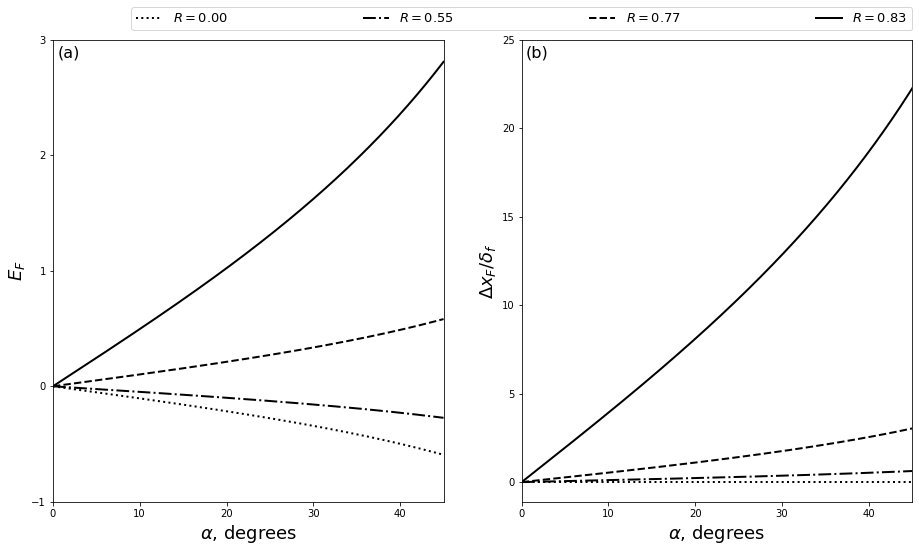

In [51]:
f, ax = plt.subplots(1, 2)
zoom = 2.0
f.set_size_inches(7.7 * zoom, 4.25 * zoom)
f.set_facecolor('w')

eps = 1.1920929e-07  # extracted from np.finfo(np.float32)
R2 = np.asarray([0.0, 0.3, 0.6, 0.69])
amax = 45.0 * np.pi/180.0
alpha = np.linspace(0.0, amax, 1000)
zeta = np.linspace(-10.0, -eps, 1000)
n = 3
plot_style = [':k', '-.k', '--k', '-k']
plots = []
labels = []

for Rsquared, pltsty in zip(R2, plot_style):
    integ = lambda z: integrand(z, Rsquared)
    ExFlx = quad(integ, -100, 0.0)
    p = ax[0].plot(alpha*180.0/np.pi, np.tan(alpha)*ExFlx[0], pltsty, linewidth=2)
    plots.append(p[0])
    labels.append('$R={:1.2f}$'.format(np.sqrt(Rsquared)))

ax[0].set_xlim(0.0, amax*180/np.pi)
ax[0].set_xticks((0, 10, 20, 30, 40))
ax[0].set_yticks((-1, 0, 1, 2, 3))
ax[0].set_xlabel(r'$\alpha$, degrees', fontsize=18)
ax[0].set_ylabel(r'$E_F$', fontsize=18)
ax[0].text(0.5, 2.95, '(a)', fontsize=16, verticalalignment='top', horizontalalignment='left')

for Rsquared, pltsty in zip(R2, plot_style):
    integ_dx = lambda z: integrand_Dx(z, Rsquared)
    ExDlx = quad(integ_dx, -100, eps)
    ax[1].plot(alpha*180.0/np.pi, np.tan(alpha)*ExDlx[0], pltsty, linewidth=2)

ax[1].set_xlim(0.0, amax*180/np.pi)
ax[1].set_xticks((0, 10, 20, 30, 40))
ax[1].set_yticks((0, 5, 10, 15, 20, 25))
ax[1].set_xlabel(r'$\alpha$, degrees', fontsize=18)
ax[1].set_ylabel(r'$\Delta x_F/\delta_f$', fontsize=18)
ax[1].text(0.5, 24.7, '(b)', fontsize=16, verticalalignment='top', horizontalalignment='left')

plt.legend(handles=plots, fontsize=13, labels=labels,
           bbox_to_anchor=(-1.0, 1.02, 2., .2),  loc='lower left', ncol=4, mode="expand", borderaxespad=0.)

plt.show()

### Lateral transport to a mid-ocean ridge